In [24]:
import torch
import pandas as pd
from network.network import PatientClassificationNet, PatientGroupNet
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
num_class = 3
num_full = 36

In [3]:
class_boundary = torch.Tensor([0.0307, 0.0739, 0.5403])
temp = PatientClassificationNet(21, 256)
net = PatientGroupNet(temp, class_boundary)

In [4]:
PATH = './model/patient_group_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [5]:
df = pd.read_excel(r'data.xlsx')
df = df[~df['Fallnummer'].isnull()]

X = df.loc[:, ['AGE', 'Admission type 2', 'No. of times sent to ICU', 'FA ab para']]
X['FA ab para'] = X['FA ab para'].replace([1, 5, 10, 14, 16, 21, 22], X['FA ab para'].max() + 1)
X = torch.Tensor(X.to_numpy())
fa_val = X[:, 3].unique()
tmp = X[:, 3].unsqueeze(1).expand((-1, len(fa_val))) == fa_val
X = torch.cat((X[:, :3], tmp.float()), dim=1)
X[:, 2] = (X[:, 2] > 1)
X = (X - X.mean(0)) / X.std(0)

Y = df.loc[:, ['Tod']]
Y = torch.Tensor(Y.to_numpy())

In [12]:
prediction = net(X).numpy()
df['class'] = prediction
los_mean = [df[df['class']==i]['LOS (Days)'].mean() for i in range(1,num_class+1)]
los_mean
num_timeslot = len(num_patients_list)

In [7]:
t = datetime(2015,1,1)
# t_end = datetime(2015, 1, 8)
t_end = datetime(2016,1,1)
t_delta = timedelta(minutes=10)
col_transfer_into_icu = df['Transfer into ICU']
col_leave_icu = df['Leave ICU']
index_list_transfer = []
index_list_leave = []
num_patients = 0
num_patients_list = []
while t < t_end:
    indices_transfer = df.loc[(col_transfer_into_icu >= t) & (col_transfer_into_icu < t+t_delta)].index
    index_list_transfer.append(indices_transfer)
    indices_leave = df.loc[(col_leave_icu >= t) & (col_leave_icu < t+t_delta)].index
    index_list_leave.append(indices_leave)
    num_patients += len(indices_transfer) - len(indices_leave)
    num_patients_list.append(num_patients)
    t = t + t_delta

In [8]:
num_patients=0
num_demand_discharge = np.zeros(num_class)
tensor_discharge = torch.zeros(len(X))
tensor_num_patients = torch.zeros(len(X))

for i in range(len(index_list_leave)):
    num_patients = num_patients_list[i-1] if i>0 else 0
    num_leave = len(index_list_leave[i])
    num_transfer = len(index_list_transfer[i])
    
    if num_leave > 0 and num_patients + num_transfer > num_full:
        pred = net(X[index_list_leave[i]])
        num_demand_discharge += [torch.sum(pred==i).item() for i in range(1,num_class+1)]
        tensor_discharge[index_list_leave[i]] = 1
    tensor_num_patients[index_list_leave[i]] = num_patients + num_transfer
        

df['Demand discharge'] = tensor_discharge.numpy()
df['Num patients'] = tensor_num_patients.numpy()

In [9]:
df_readmit = df[df['No. of times sent to ICU'] > 1]
readmit_id = df_readmit['Fallnummer'].unique()

# Find readmit patients who demand discharged at first entrance to ICU
df['Demand discharge first'] = df['Demand discharge'].copy()
df['LOS first'] = df['LOS (Days)'].copy()
readmit_discharge_first_id = df[df['Fallnummer'].isin(readmit_id) & (df['No. of times sent to ICU'] == 1) & (df['Demand discharge']==1)]['Fallnummer'].unique()
df.loc[df[df['Fallnummer'].isin(readmit_discharge_first_id)].index, 'Demand discharge first'] = 1

# Update LOS first admission to ICU
tmp = df[df['Fallnummer'].isin(readmit_id) & (df['No. of times sent to ICU'] == 1)][['Fallnummer', 'LOS first']]
df.set_index('Fallnummer', inplace=True)
df.update(tmp.set_index('Fallnummer'))
df = df.reset_index()

In [22]:
condition_low = df['Demand discharge first'] == 0
condition_class = lambda x: df['class'] == x
condition_alive = ~(df['Dispatch to'] == 'Tod')
condition_readmit = df['No. of times sent to ICU'] > 1
condition_low_now = df['Demand discharge'] == 0

mu_r_low = []
p_r_low = []
mu_r_full = []
p_r_full = []
p_arrive = []
for i in range(1, num_class+1):
#     df_cond = df[condition_low & condition_class(i) & condition_alive]
#     mu_low.append(df_cond['LOS first'].sum() / len(df_cond))
    
    df_cond = df[condition_low & condition_class(i)]
    df_cond2 = df[condition_readmit & condition_low & condition_class(i)]
    p_r_low.append(len(df_cond2.index) / len(df_cond.index))
    
    df_cond = df[~condition_low & condition_class(i)]
    df_cond2 = df[condition_readmit & ~condition_low & condition_class(i)]
    p_r_full.append(len(df_cond2.index) / len(df_cond.index))
    
    df_cond = df[condition_low & condition_readmit & condition_class(i) & condition_low_now & condition_alive]
    mu_r_low.append(1 / (df_cond['LOS (Days)'].sum() / len(df_cond.index)))
    
    df_cond = df[~condition_low & condition_readmit & condition_class(i) & condition_low_now & condition_alive]
    mu_r_full.append(1 / (df_cond['LOS (Days)'].sum() / len(df_cond.index)))
    
    df_cond = df[condition_class(i)]
    p_arrive.append(len(df_cond) / num_timeslot)

p_arrive = [1 - np.sum(p_arrive)] + p_arrive
delta_readmission_load = [p_r_full[i] / mu_r_full[i] - p_r_low[i] / mu_r_low[i] for i in range(len(mu_r_full))]
print(p_r_low)
print(p_r_full)
print(mu_r_low)
print(mu_r_full)
print(p_arrive)
print(delta_readmission_load)


[0.012557077625570776, 0.027216856892010536, 0.13576779026217228]
[0.020518358531317494, 0.04817275747508306, 0.2980225988700565]
[0.4379804236002934, 0.21230084086524306, 0.2308742281443453]
[0.18798955613585186, 0.25997993981984696, 0.21490256423879353]
[0.8988013698630137, 0.03428462709284627, 0.033124048706240486, 0.033789954337899546]
[0.08047585987623804, 0.057094655130521615, 0.7987205662123528]


In [26]:
from DataProcess import DataProcess

dp = DataProcess(net, 3)
result = dp.process()

NameError: name 'net' is not defined

ValueError: x and y must have same first dimension, but have shapes (3624,) and (52560,)

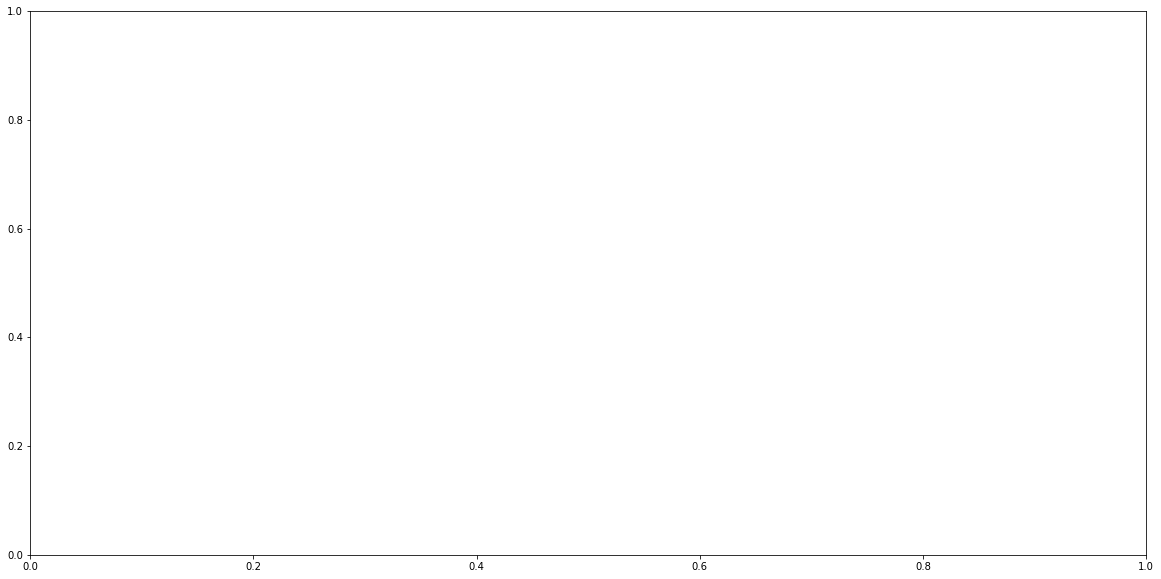

In [11]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(151*24), num_patients_list)